In [1]:
import torch.utils.data
from torchvision.utils import save_image
from net import *
from model import Model
from checkpointer import Checkpointer
from dlutils.pytorch import count_parameters
from defaults import get_cfg_defaults
import lreq
import logging
from io import BytesIO
import imageio
from tqdm import tqdm
import dareblopy as db
from dataloader import *

from PIL import Image, ImageEnhance
import glob

In [2]:
print('Loading config...')
config_file='configs/popgan.yaml'
cfg = get_cfg_defaults()
cfg.merge_from_file(config_file)
cfg.freeze()

print('Initializing model...')
torch.cuda.set_device(0)
layer_count = cfg.MODEL.LAYER_COUNT
model = Model(
    startf=cfg.MODEL.START_CHANNEL_COUNT,
    layer_count=cfg.MODEL.LAYER_COUNT,
    maxf=cfg.MODEL.MAX_CHANNEL_COUNT,
    latent_size=cfg.MODEL.LATENT_SPACE_SIZE,
    truncation_psi=cfg.MODEL.TRUNCATIOM_PSI,
    truncation_cutoff=cfg.MODEL.TRUNCATIOM_CUTOFF,
    mapping_layers=cfg.MODEL.MAPPING_LAYERS,
    channels=cfg.MODEL.CHANNELS,
    generator=cfg.MODEL.GENERATOR,
    encoder=cfg.MODEL.ENCODER)
model.cuda(0)
model.eval()
model.requires_grad_(False)

print('Loading checkpoint...')
model_dict = {
    'discriminator_s': model.encoder,
    'generator_s': model.decoder,
    'mapping_tl_s': model.mapping_tl,
    'mapping_fl_s': model.mapping_fl,
    'dlatent_avg': model.dlatent_avg
}
checkpointer = Checkpointer(cfg, model_dict)
extra_checkpoint_data = checkpointer.load(file_name='training_artifacts/popgan/model_tmp_lod8_e200.pth')

print('READY!')

Loading config...
Initializing model...
Loading checkpoint...
READY!


In [3]:
def encode(x, pop):
    x_pop = torch.cat((x, pop), 1)
    zlist = []
    for i in range(x_pop.shape[0]):
        Z, _ = model.encode(x_pop[i][None, ...], layer_count - 1, 1)
        zlist.append(Z)
    Z = torch.cat(zlist)
    Z = Z.repeat(1, model.mapping_fl.num_layers, 1)
    return Z

noises = [[
        0,
        torch.randn([1, 1, 2, 2]),
        torch.randn([1, 1, 4, 4]),
        torch.randn([1, 1, 8, 8]),
        torch.randn([1, 1, 16, 16]),
        torch.randn([1, 1, 32, 32]),
        torch.randn([1, 1, 64, 64]),
        torch.randn([1, 1, 128, 128]),
        torch.randn([1, 1, 256, 256]),
        torch.randn([1, 1, 512, 512]),
        torch.randn([1, 1, 1024, 1024])
    ] for i in range(10)]

def sample_z(seed):
    with torch.no_grad():
        rng = np.random.RandomState(seed)
        z = rng.standard_normal(cfg.MODEL.LATENT_SPACE_SIZE)
        z = torch.from_numpy(z).float().cuda().unsqueeze(0)
    return z

def z2w(z):
    with torch.no_grad():
        w = model.mapping_fl(z)
    return w

def decode(w, pop, noise_i=0):
    return torch.clamp(model.decoder(w, pop, layer_count - 1, 1, noise=noises[noise_i]), -1., 1.)

def mix_styles(style_shallow, style_deep, layer_range, strength):
    style = style_shallow.clone()
    style[layer_range, :] = (style_deep[layer_range, :] * strength) + (style_shallow[layer_range, :] * (1-strength))
    return style

def tensor_to_numpy(img):
    img = img * 0.5 + 0.5
    img = img.cpu().squeeze().numpy()
    img = np.clip(img, 0, 1)
    if len(img.shape) == 3:
        img = np.moveaxis(img, 0, 2)
    img = (img *255).astype(np.uint8)
    return img

def tensor_to_PIL(img):
    img = Image.fromarray(tensor_to_numpy(img))
    img = ImageEnhance.Brightness(img).enhance(1.4)
    img = ImageEnhance.Contrast(img).enhance(1.4)
    return img

def load_image(path):
    im_raw = Image.open(path)
    im = im_raw.resize((1024, 1024))
    im = np.asarray(im)
    x = numpy_to_tensor(im)
    return im_raw, x

def numpy_to_tensor(im):
    if len(im.shape) < 3:
        im = np.expand_dims(im, 2)
    im = im.transpose((2, 0, 1))
    x = torch.tensor(np.asarray(im, dtype=np.float32), requires_grad=False).cuda() / 127.5 - 1.
    return x

def numpy_to_PIL(img):
    img = np.clip(img, 0, 1)
    img = (img *255).astype(np.uint8)
    img = Image.fromarray(img)
    img = img.resize((1024, 1024))
    return img

def save_mp4_from_images(dst, images):
    writer = imageio.get_writer(dst, fps=10)
    for img in tqdm(images):
        writer.append_data(img)
    writer.close()
    
def db_to_tensor(im):
    x = torch.tensor(np.asarray(im, dtype=np.float32), requires_grad=False).cuda() / 127.5 - 1.
    return x

def add_horizontal_line(tensor):
    tensor[:, 0, :] = 1.
    tensor[:, tensor.shape[1]-1, :] = 1.
    return tensor

In [4]:
example_populations = []
example_populations_paths = sorted(glob.glob('SCALAE_paper_figures/example_populations/*.png'))
for path in example_populations_paths:
    example_populations.append(numpy_to_tensor(np.asarray(Image.open(path))))

In [5]:
z = sample_z(451)
w_fake = z2w(z)

final_img_grids = []

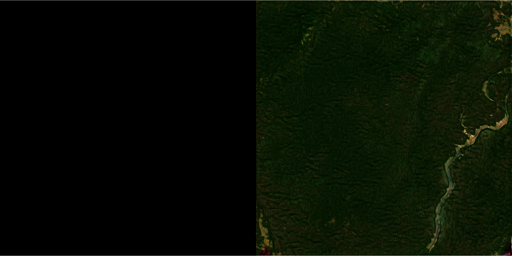

In [6]:
crop_size = 1024
pop_zero = torch.ones((1024, 1024), dtype=torch.float32, requires_grad=False) * -1.
pop_zero = pop_zero.unsqueeze(0).unsqueeze(0).cuda()
img_fake = decode(w_fake, pop_zero)
img_grid = Image.new('RGBA', (2*crop_size, crop_size), (255, 255, 255, 255))
img_grid.paste(tensor_to_PIL(add_horizontal_line(pop_zero[0, :])).resize((crop_size,crop_size)), (0 * crop_size, 0 * crop_size))
img_grid.paste(tensor_to_PIL(add_horizontal_line(img_fake[0, :])).resize((crop_size,crop_size)), (1 * crop_size, 0 * crop_size))

if len(final_img_grids) > 1:
    final_img_grids[0] = img_grid
else:
    final_img_grids.append(img_grid)

thumbnail_size = 256
img_grid.resize((2*thumbnail_size, 1*thumbnail_size))

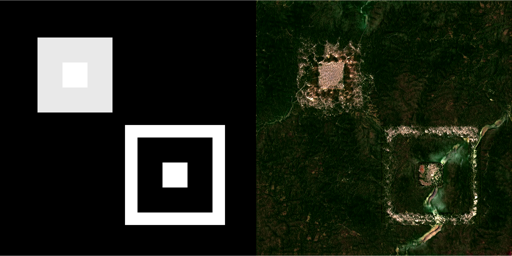

In [7]:
crop_size = 1024
pop_squares = torch.ones((1024, 1024), dtype=torch.float32, requires_grad=False) * -1.
pop_squares[150:450, 150:450] = 0.0
pop_squares[250:350, 250:350] = 1.0
pop_squares[500:900, 500:900] = 0.5
pop_squares[550:850, 550:850] = -1.0
pop_squares[650:750, 650:750] = 1.0
pop_squares = pop_squares.unsqueeze(0).unsqueeze(0).cuda()
img_fake = decode(w_fake, pop_squares)
img_grid = Image.new('RGBA', (2*crop_size, crop_size), (255, 255, 255, 255))
img_grid.paste(tensor_to_PIL(add_horizontal_line(pop_squares[0, :])).resize((crop_size,crop_size)), (0 * crop_size, 0 * crop_size))
img_grid.paste(tensor_to_PIL(add_horizontal_line(img_fake[0, :])).resize((crop_size,crop_size)), (1 * crop_size, 0 * crop_size))
if len(final_img_grids) > 2:
    final_img_grids[1] = img_grid
else:
    final_img_grids.append(img_grid)

thumbnail_size = 256
img_grid.resize((2*thumbnail_size, 1*thumbnail_size))

In [8]:
crop_size = 1024
for pop in example_populations:
    
    pop = pop.unsqueeze(0)
    img_fake = decode(w_fake, pop)

    img_grid = Image.new('RGBA', (2*crop_size, crop_size), (255, 255, 255, 255))
    img_grid.paste(tensor_to_PIL(add_horizontal_line(pop[0, :])).resize((crop_size,crop_size)), (0 * crop_size, 0 * crop_size))
    img_grid.paste(tensor_to_PIL(add_horizontal_line(img_fake[0, :])).resize((crop_size,crop_size)), (1 * crop_size, 0 * crop_size))

    final_img_grids.append(img_grid)

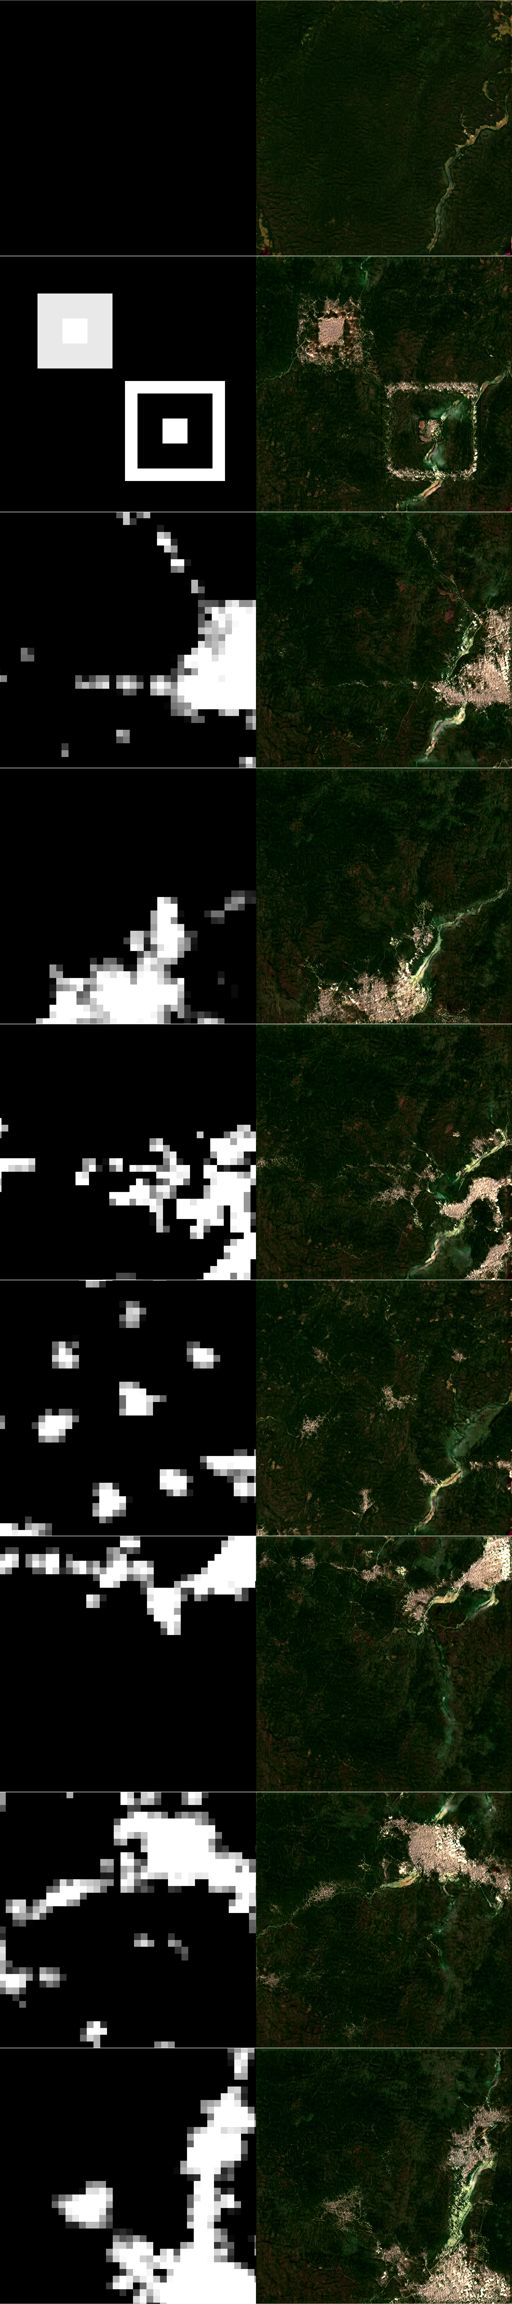

In [9]:
crop_size = 1024
n = len(final_img_grids)
img_grid = Image.new('RGBA', (2*crop_size, n*crop_size), (255, 255, 255, 255))
for i in range(n):
    img = final_img_grids[i]
    img_grid.paste(img, (0 * crop_size, i * crop_size))

img_grid.save('SCALAE_paper_figures/vary_population.png')
thumbnail_size = 256
img_grid.resize((2*thumbnail_size, n*thumbnail_size))

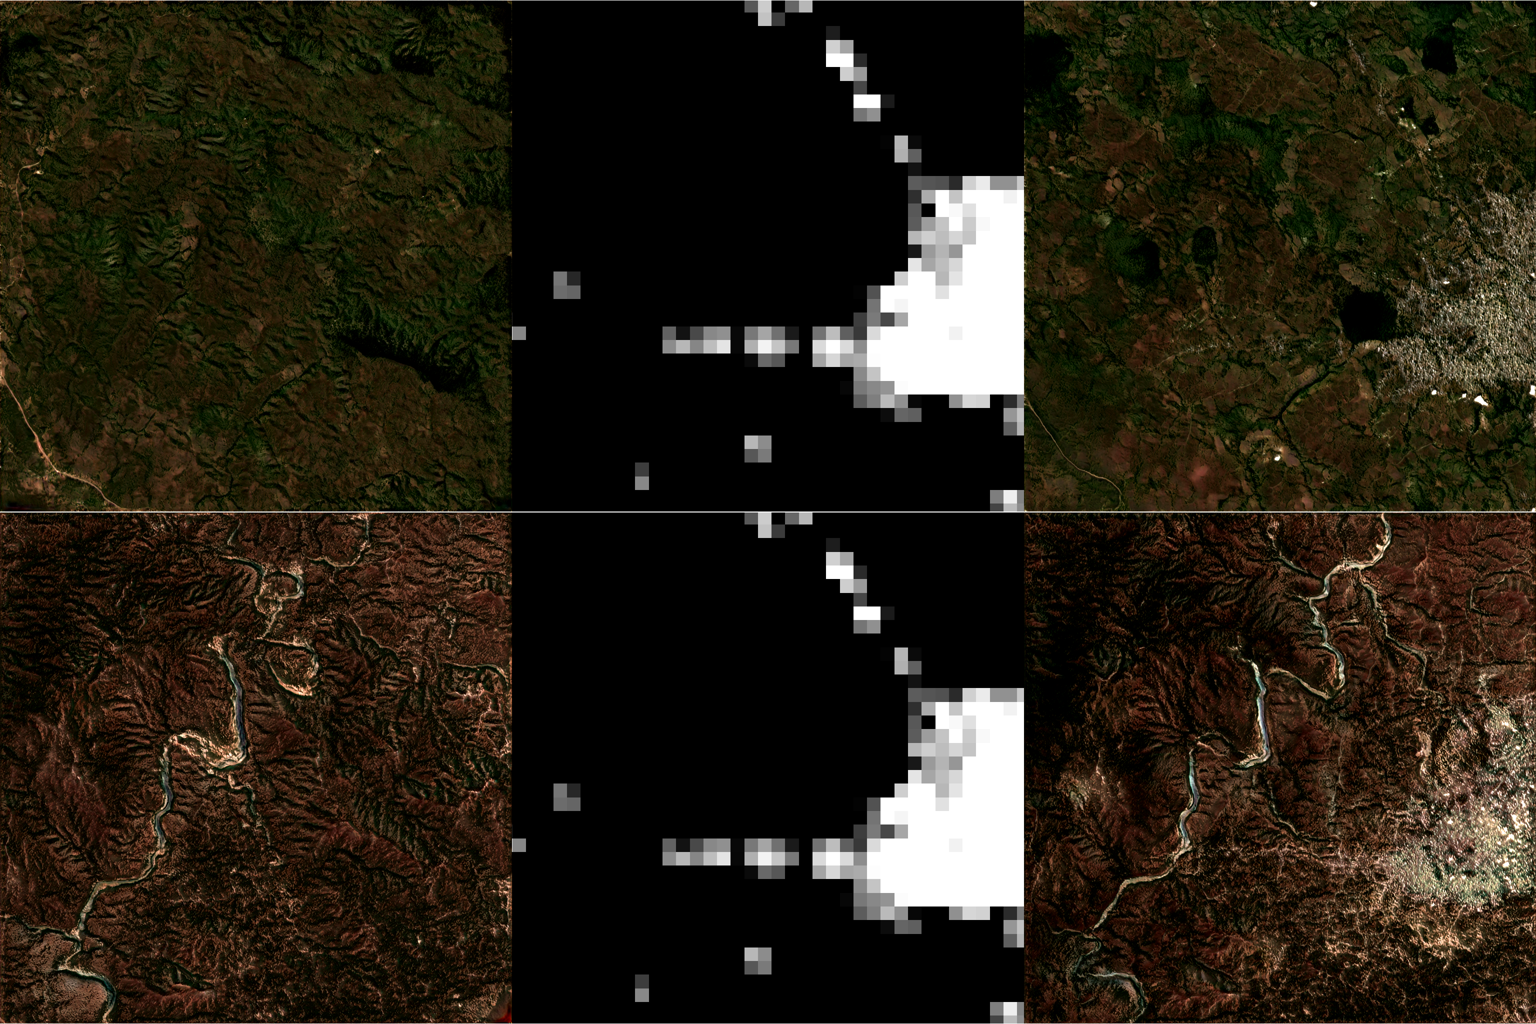

In [10]:
crop_size = 1024
pop_ind = 0
selected_indices = [1,2]
n = len(selected_indices)
img_grid = Image.new('RGBA', (3*crop_size, n*crop_size), (255, 255, 255, 255))
for i, ind in enumerate(selected_indices):
    z = sample_z(ind)
    w_fake = z2w(z)
    img_zero = decode(w_fake, pop_zero)
    pop = example_populations[pop_ind].unsqueeze(0)
    img_fake = decode(w_fake, pop)

    img_grid.paste(tensor_to_PIL(add_horizontal_line(img_zero[0, :])).resize((crop_size,crop_size)), (0 * crop_size, i * crop_size))
    img_grid.paste(tensor_to_PIL(add_horizontal_line(pop[0, :])).resize((crop_size,crop_size)), (1 * crop_size, i * crop_size))
    img_grid.paste(tensor_to_PIL(add_horizontal_line(img_fake[0, :])).resize((crop_size,crop_size)), (2 * crop_size, i * crop_size))

img_grid.save('SCALAE_paper_figures/vary_latent_1.png')
thumbnail_size = 512
img_grid.resize((3*thumbnail_size, n*thumbnail_size))

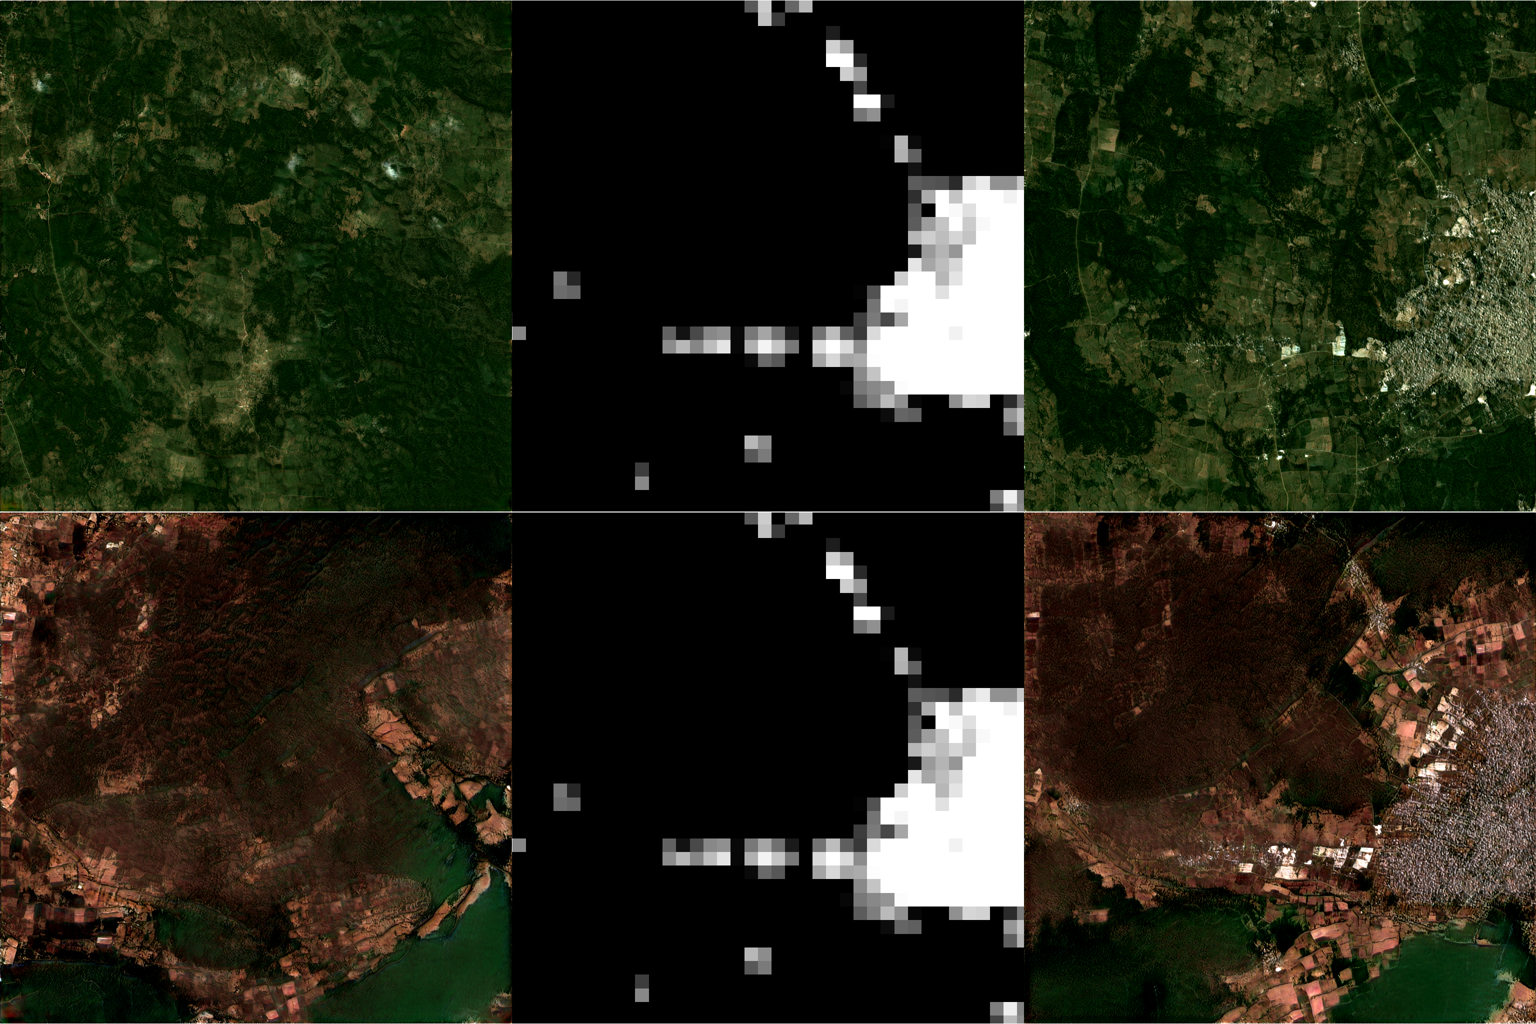

In [11]:
crop_size = 1024
pop_ind = 0
selected_indices = [5,9]
n = len(selected_indices)
img_grid = Image.new('RGBA', (3*crop_size, n*crop_size), (255, 255, 255, 255))
for i, ind in enumerate(selected_indices):
    z = sample_z(ind)
    w_fake = z2w(z)
    img_zero = decode(w_fake, pop_zero)
    pop = example_populations[pop_ind].unsqueeze(0)
    img_fake = decode(w_fake, pop)

    img_grid.paste(tensor_to_PIL(add_horizontal_line(img_zero[0, :])).resize((crop_size,crop_size)), (0 * crop_size, i * crop_size))
    img_grid.paste(tensor_to_PIL(add_horizontal_line(pop[0, :])).resize((crop_size,crop_size)), (1 * crop_size, i * crop_size))
    img_grid.paste(tensor_to_PIL(add_horizontal_line(img_fake[0, :])).resize((crop_size,crop_size)), (2 * crop_size, i * crop_size))

img_grid.save('SCALAE_paper_figures/vary_latent_2.png')
thumbnail_size = 512
img_grid.resize((3*thumbnail_size, n*thumbnail_size))